In [1]:

import pickle
import networkx as nx
from node2vec import Node2Vec
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import math
from networkx import to_numpy_matrix

In [2]:
EMBEDDING_FILENAME = './embeddings.emb'
EMBEDDING_MODEL_FILENAME = './embeddings.model'

In [3]:
# functions

#display graph
def display_graph(G):
    plt.figure(figsize=(12,12))
    nx.draw(G, node_size=80, node_color='yellow', with_labels=True, nodetype = int)
    return

# node2vec for each node
def create_n2v_dict(G):
    # get node to vec embeddings
    node2vec = Node2Vec(G, dimensions=50, walk_length=5, num_walks=5, workers=4)  
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  
    model.wv.save_word2vec_format(EMBEDDING_FILENAME)
    model.save(EMBEDDING_MODEL_FILENAME)
    emb = pd.read_csv(EMBEDDING_FILENAME, "r")
    
    n2v = dict()
    for i in range(len(emb)):
        tmp = list(emb.iloc[i])[0].split(" ")
        n2v[tmp[0]] = list(map(float, tmp[1:]))
    return n2v


In [4]:
#Extracting dataframes

feat_names = pd.read_csv("facebook/0.featnames")
edges = pd.read_csv("facebook/0.edges")
feat = pd.read_csv("facebook/0.feat")
circles = pd.read_csv("facebook/0.circles")

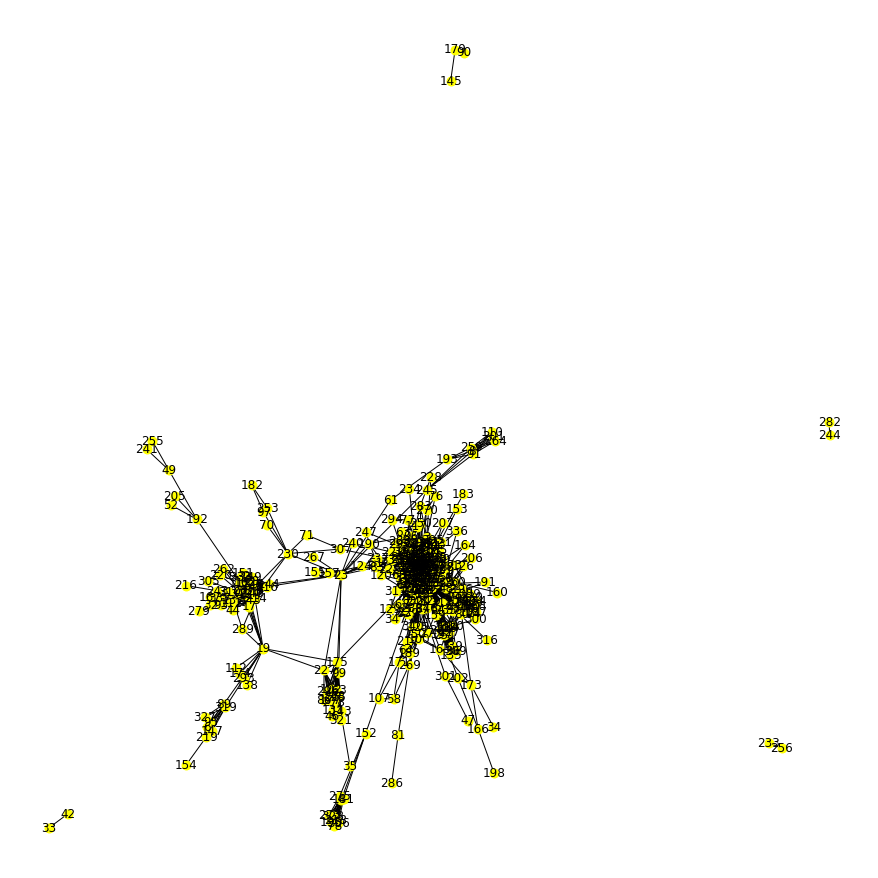

In [5]:
# building the graph

#edgelist is needed for read_edgelist
edge_df = open("facebook/0.edges", "rb")
G = nx.read_edgelist(edge_df)
display_graph(G)
        

In [6]:
#Building edge_dic

# getting nodes and edges for dataframe from graph
print(len(G.nodes))
print(len(G.edges))

node_list = list(np.unique(G.nodes))
edge_list = list(G.edges)


entries = []

# all_edges dictionary
edge_dict = dict()


for node1 in node_list:
    for node2 in node_list:
        if node1 != node2 and (node1, node2) not in edge_dict and (node2, node1) not in edge_dict:
            if (node1, node2) in edge_list:
                edge_dict[(node1, node2)] = 1
            elif (node2, node1) in edge_list:
                edge_dict[(node2, node1)] = 1
            else:
                edge_dict[(node1, node2)] = 0
                
print(len(edge_list))
print(len(edge_dict))                


333
2519
2519
55278


In [7]:
n2v = create_n2v_dict(G)

Computing transition probabilities: 100%|██████████| 333/333 [00:01<00:00, 259.29it/s]


In [9]:
'''df = pd.DataFrame(columns = ['source_node', 'dest_node', 'edge_exists', 'source_n2v', 'dest_n2v'])      

index = 0
for edge in edge_dict:
    row = [edge[0], edge[1], edge_dict[edge], n2v[edge[0]], n2v[edge[1]]]
    df.loc[index] = row
    index += 1'''

"df = pd.DataFrame(columns = ['source_node', 'dest_node', 'edge_exists', 'source_n2v', 'dest_n2v'])      \n\nindex = 0\nfor edge in edge_dict:\n    row = [edge[0], edge[1], edge_dict[edge], n2v[edge[0]], n2v[edge[1]]]\n    df.loc[index] = row\n    index += 1"

In [11]:

#file = open('df.pickle', 'wb')
#pickle.dump(df, file)

file = open('df.pickle', 'rb')
df = pickle.load(file)
print(df.head)

<bound method NDFrame.head of       source_node dest_node edge_exists  \
0               1        10           0   
1               1       100           0   
2               1       101           0   
3               1       102           0   
4               1       103           0   
...           ...       ...         ...   
55273          96        98           0   
55274          96        99           0   
55275          97        98           0   
55276          97        99           0   
55277          98        99           0   

                                              source_n2v  \
0      [-0.030292315, 0.002790003, 0.04125119, -0.023...   
1      [-0.030292315, 0.002790003, 0.04125119, -0.023...   
2      [-0.030292315, 0.002790003, 0.04125119, -0.023...   
3      [-0.030292315, 0.002790003, 0.04125119, -0.023...   
4      [-0.030292315, 0.002790003, 0.04125119, -0.023...   
...                                                  ...   
55273  [-0.020762097, -0.00194563

2519 2016


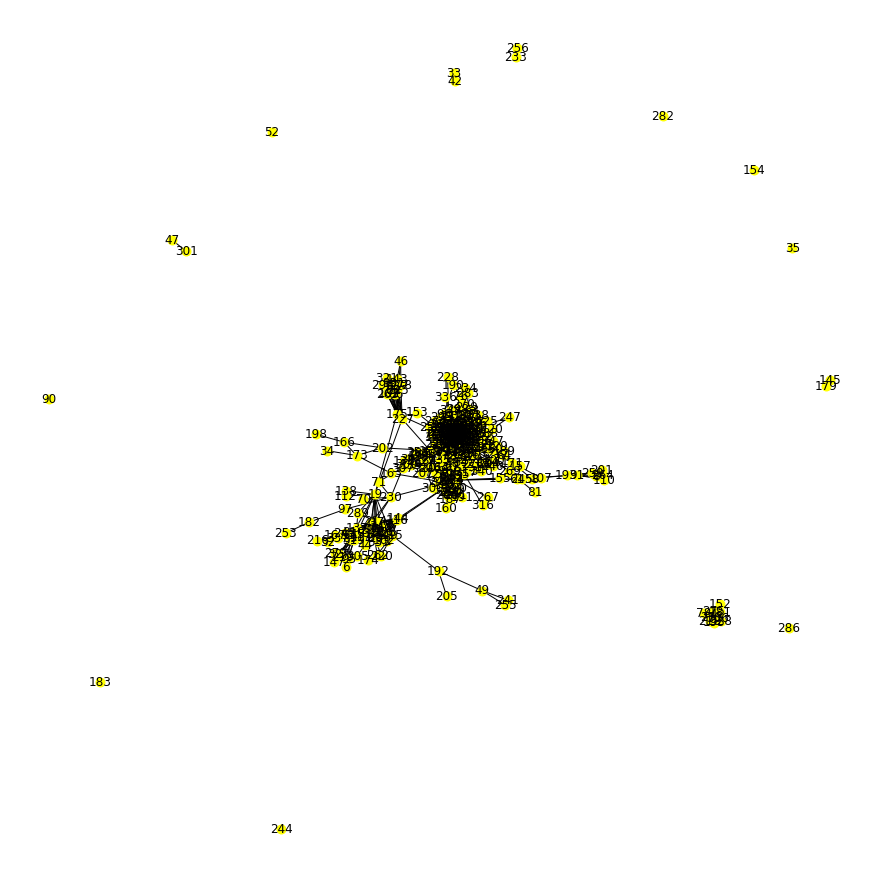

In [13]:
#build train graph

train_graph = nx.Graph()
train_graph.add_nodes_from(node_list)

train_edge_list = random.sample(edge_list, math.ceil(0.8*len(edge_list)))
train_edge_list = [(i,j) for i,j in train_edge_list]
train_graph.add_edges_from(train_edge_list)
print(len(edge_list), len(train_edge_list))
display_graph(train_graph)


In [15]:
# Buildind dataframe for train graph
#print(node_list)
train_df = pd.DataFrame(columns = ['source_node', 'dest_node', 'edge_exists', 'source_n2v', 'dest_n2v'])      

for i in range(len(train_edge_list)):      
    edge = train_edge_list[i]
    entry = [edge[0], edge[1], edge_dict[edge], n2v[edge[0]], n2v[edge[1]]]
    train_df.loc[i] = entry

print(train_df.head)
        

<bound method NDFrame.head of      source_node dest_node edge_exists  \
0            322        21           1   
1             98       238           1   
2            272       178           1   
3            339       260           1   
4            133         1           1   
...          ...       ...         ...   
2011          46       177           1   
2012          56       161           1   
2013          67       196           1   
2014         304        56           1   
2015          83       237           1   

                                             source_n2v  \
0     [0.051651772, -0.021435907, -0.093434125, 0.04...   
1     [0.036001183, -0.012914707, -0.06993859, 0.033...   
2     [0.026881967, -0.010497203, -0.06393675, 0.039...   
3     [0.024324663, -0.0136752855, -0.051604945, 0.0...   
4     [0.030539617, -0.0011613636, -0.043551274, 0.0...   
...                                                 ...   
2011  [0.012350414, -0.0083869, -0.042310365, 0.0211